# Session 4 - Model Evaluation

Here we will consider Classification ML Problem for Churn prediction

In [6]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv('./data/churn_data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

# fix errors in data type in column totalcharges:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce') # convert to numeric as save errors as NaN
df['totalcharges'] = df['totalcharges'].fillna(0)

# change churn sign from 'yes/no' to 1/0:
df['churn'] = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod'
    ]

In [14]:
dicts_train = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred_decision = (y_pred >= 0.5).astype(int)
accuracy = (y_pred_decision == y_val).mean()
print(f'Accuracy = {accuracy}')

Accuracy = 0.8034066713981547


Now our task is to take a closer look at the Accuracy and compare it to a Base line model, to understand how good this number really is

# Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

Model output above was the probability of Churn, and then me made decisions based on the Threshold P >= 0.5 is churn  
But why we took this threshold? Could another value produce Better Accuracy result?

In [17]:
# let's try to iterate by this Threshold:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print(f'Threshold = {round(t, 3)},  Accuracy = {round(score, 3)}')

Threshold = 0.0,  Accuracy = 0.274
Threshold = 0.05,  Accuracy = 0.51
Threshold = 0.1,  Accuracy = 0.592
Threshold = 0.15,  Accuracy = 0.666
Threshold = 0.2,  Accuracy = 0.71
Threshold = 0.25,  Accuracy = 0.739
Threshold = 0.3,  Accuracy = 0.76
Threshold = 0.35,  Accuracy = 0.772
Threshold = 0.4,  Accuracy = 0.785
Threshold = 0.45,  Accuracy = 0.793
Threshold = 0.5,  Accuracy = 0.803
Threshold = 0.55,  Accuracy = 0.801
Threshold = 0.6,  Accuracy = 0.796
Threshold = 0.65,  Accuracy = 0.786
Threshold = 0.7,  Accuracy = 0.766
Threshold = 0.75,  Accuracy = 0.744
Threshold = 0.8,  Accuracy = 0.735
Threshold = 0.85,  Accuracy = 0.726
Threshold = 0.9,  Accuracy = 0.726
Threshold = 0.95,  Accuracy = 0.726
Threshold = 1.0,  Accuracy = 0.726


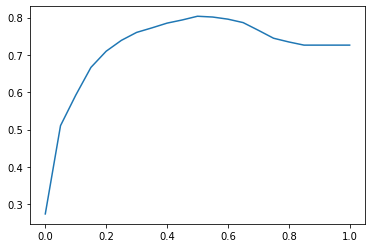

In [20]:
# let's visualize results:
plt.plot(thresholds, scores)

We can see that Threshold = 0.5 has highest Accuracy score

In [21]:
from sklearn.metrics import accuracy_score

The interesting observation we can make, is located at the Last point of the Graph:  
- there we make a decision, that the customer is going to churn by Prob >= 1, and we have accuracy around 70%,  
- however, there are no such values in the Validation dataset:

In [23]:
(y_pred >= 1).sum()

0

In [24]:
# Using Counter:
from collections import Counter

Counter(y_pred >= 1)

Counter({False: 1409})

We can see that there are only False values in that case

- Dummy model - in this example we gave only negative predictions only, but still got 73 % accuracy!

the reason for this is inside of classes distribution:

In [25]:
# distribution of y:
Counter(y_val)

Counter({0: 1023, 1: 386})

we can see that there are a lot more non-churning users then others, dummy model simply missing all churning users

This is due to the Class imbalance (3:1 non-churning/churning) 

therefore, accuracy cannot be the only model performance metric especially for Class imbalance cases and we need some other Metrics to Measure model's quality